In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import median_filter
from tqdm import tqdm
import os
import re

TRACE_DIR = 'powerless_traces'
THRESHOLD = 0.1825
OPERATION_WIDTH = 370
MIN_GAP = 100
NUM_BYTES = 12
SEARCH_WINDOW = 400

### CPA Helper Functions

In [ ]:
def calculate_moving_variance(trace, window_size=50):
    variance = np.array([np.var(trace[i:i+window_size])
                         for i in range(len(trace)-window_size)])
    variance = np.pad(variance, (0, window_size), mode='edge')
    return variance

def normalize_array(arr):
    return (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

HW = [bin(n).count("1") for n in range(256)]

def xor_internal(mask, key_guess):
    return (mask-key_guess)%256

def align_trace_window(reference_window, trace, ref_start, search_window=200):
    window_len = len(reference_window)
    search_start = max(0, ref_start - search_window)
    search_end = min(len(trace) - window_len, ref_start + search_window)
    min_sad = float('inf')
    aligned_start = ref_start
    
    for pos in range(search_start, search_end + 1):
        trace_window = trace[pos:pos + window_len]
        if len(trace_window) == window_len:
            sad = np.sum(np.abs(reference_window - trace_window))
            if sad < min_sad:
                min_sad = sad
                aligned_start = pos
    
    return aligned_start, min_sad

def mean(X):
    return np.sum(X, axis=0) / len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X - X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X - X_bar) * (Y - Y_bar), axis=0)

### Window Identification Function

In [3]:
def identify_byte_windows(trace, num_bytes=12, operation_width=310,
                          threshold=0.164, min_gap=100, plot=True):
    trace = np.array(trace)

    window_size = 50
    variance = calculate_moving_variance(trace, window_size)
    variance_norm = normalize_array(variance)
    variance_smooth = median_filter(variance_norm, size=10)

    high_activity = variance_smooth > threshold
    first_window_end = operation_width

    transitions = np.diff(high_activity.astype(int))
    all_operation_starts = np.where(transitions == 1)[0] + 1

    subsequent_starts = [s for s in all_operation_starts if s >= first_window_end]

    filtered_starts = [0]
    last_start = 0

    for start in subsequent_starts:
        if start - last_start >= min_gap:
            filtered_starts.append(start)
            last_start = start
            if len(filtered_starts) >= num_bytes:
                break

    final_windows = []
    for i, start in enumerate(filtered_starts[:num_bytes]):
        end = min(len(trace), start + operation_width)
        final_windows.append((start, end))

    if len(final_windows) < num_bytes:
        print(f"\nWarning: Found only {len(final_windows)} windows, expected {num_bytes}")

    print(f"\nIdentified {len(final_windows)} byte operation windows:")
    for i, (start, end) in enumerate(final_windows):
        width = end - start
        if i > 0:
            gap = start - final_windows[i-1][1]
            period = start - final_windows[i-1][0]
            print(f"  Byte {i}: [{start:5d}, {end:5d}] - width={width:3d} - gap={gap:3d} - period={period:3d}")
        else:
            print(f"  Byte {i}: [{start:5d}, {end:5d}] - width={width:3d}")

    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18, 12))

        ax1.plot(trace, linewidth=0.5, alpha=0.8)
        ax1.set_title('Reference Power Trace (trace0)', fontsize=14)
        ax1.set_ylabel('Power', fontsize=12)
        ax1.grid(True, alpha=0.3)

        ax2.plot(variance_smooth, linewidth=1, color='blue')
        ax2.axhline(y=threshold, color='r', linestyle='--',
                   label=f'Threshold={threshold:.4f}', linewidth=2)
        for start in filtered_starts[:num_bytes]:
            ax2.axvline(x=start, color='green', linestyle=':', alpha=0.7, linewidth=1.5)
        ax2.set_title(f'Moving Variance (threshold={threshold:.4f}, min_gap={min_gap})',
                     fontsize=14)
        ax2.set_ylabel('Normalized Variance', fontsize=12)
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)

        ax3.plot(trace, linewidth=0.5, alpha=0.6, color='black')
        colors = plt.cm.tab10(np.linspace(0, 1, num_bytes))
        for i, (start, end) in enumerate(final_windows):
            ax3.axvspan(start, end, alpha=0.3, color=colors[i],
                       label=f'Byte {i}')
        ax3.set_title(f'Reference Trace with {len(final_windows)} Identified Byte Windows',
                     fontsize=14)
        ax3.set_xlabel('Sample', fontsize=12)
        ax3.set_ylabel('Power', fontsize=12)
        ax3.legend(bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=9)
        ax3.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig('identified_windows.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\nWindow identification plot saved")

    return np.array(final_windows)

### Trace Loading

In [4]:
print("Loading traces...")

all_files = sorted([f for f in os.listdir(TRACE_DIR) if f.endswith('.npy')])

indices = []
plaintext_arrays = []

for f in all_files:
    match = re.match(r'trace(\d+)_passwd_sent(-?\d+(?:--?\d+)*).npy', f)
    if match:
        indices.append(int(match.group(1)))
        byte_str = match.group(2)
        bytes_list = [int(b) for b in byte_str.split('-') if b]
        plaintext_arrays.append(bytes_list)

sorted_tuples = sorted(zip(indices, all_files, plaintext_arrays))
sorted_files = [t[1] for t in sorted_tuples]
sorted_plaintexts = [t[2] for t in sorted_tuples]

traces = np.array([np.load(os.path.join(TRACE_DIR, f)) for f in sorted_files])

max_bytes = max(len(p) for p in sorted_plaintexts)
plaintexts_array = np.zeros((len(sorted_plaintexts), max_bytes), dtype=np.uint8)

for i, pt in enumerate(sorted_plaintexts):
    for j, byte_val in enumerate(pt):
        plaintexts_array[i, j] = byte_val if byte_val >= 0 else (256 + byte_val)

print(f"Loaded {traces.shape[0]} traces, {traces.shape[1]} samples each")
print(f"Number of bytes per plaintext: {plaintexts_array.shape[1]}")
print(f"First 5 plaintexts:")
for i in range(min(5, len(plaintexts_array))):
    print(f"  Trace {i}: {' '.join(f'{int(b):3d}' for b in plaintexts_array[i])}")

Loading traces...
Loaded 5000 traces, 13000 samples each
Number of bytes per plaintext: 12
First 5 plaintexts:
  Trace 0:   9 221 133 206 227 138 104 179  65 136 164 104
  Trace 1:  66 128  87 216 108  44 212 200  81 217 185 211
  Trace 2: 221   5 193 153  30 165 146 146  27 241 228 128
  Trace 3:   3 166 183   9 113 214 214  76 100 104  60  76
  Trace 4:  82   7 137 196  26 194 179  80 183 119  75 196


### Window Identification


Identifying byte operation windows...

Identified 12 byte operation windows:
  Byte 0: [    0,   370] - width=370
  Byte 1: [  902,  1272] - width=370 - gap=532 - period=902
  Byte 2: [ 1808,  2178] - width=370 - gap=536 - period=906
  Byte 3: [ 2788,  3158] - width=370 - gap=610 - period=980
  Byte 4: [ 3816,  4186] - width=370 - gap=658 - period=1028
  Byte 5: [ 4784,  5154] - width=370 - gap=598 - period=968
  Byte 6: [ 5776,  6146] - width=370 - gap=622 - period=992
  Byte 7: [ 6708,  7078] - width=370 - gap=562 - period=932
  Byte 8: [ 7631,  8001] - width=370 - gap=553 - period=923
  Byte 9: [ 8550,  8920] - width=370 - gap=549 - period=919
  Byte 10: [ 9467,  9837] - width=370 - gap=547 - period=917
  Byte 11: [10400, 10770] - width=370 - gap=563 - period=933


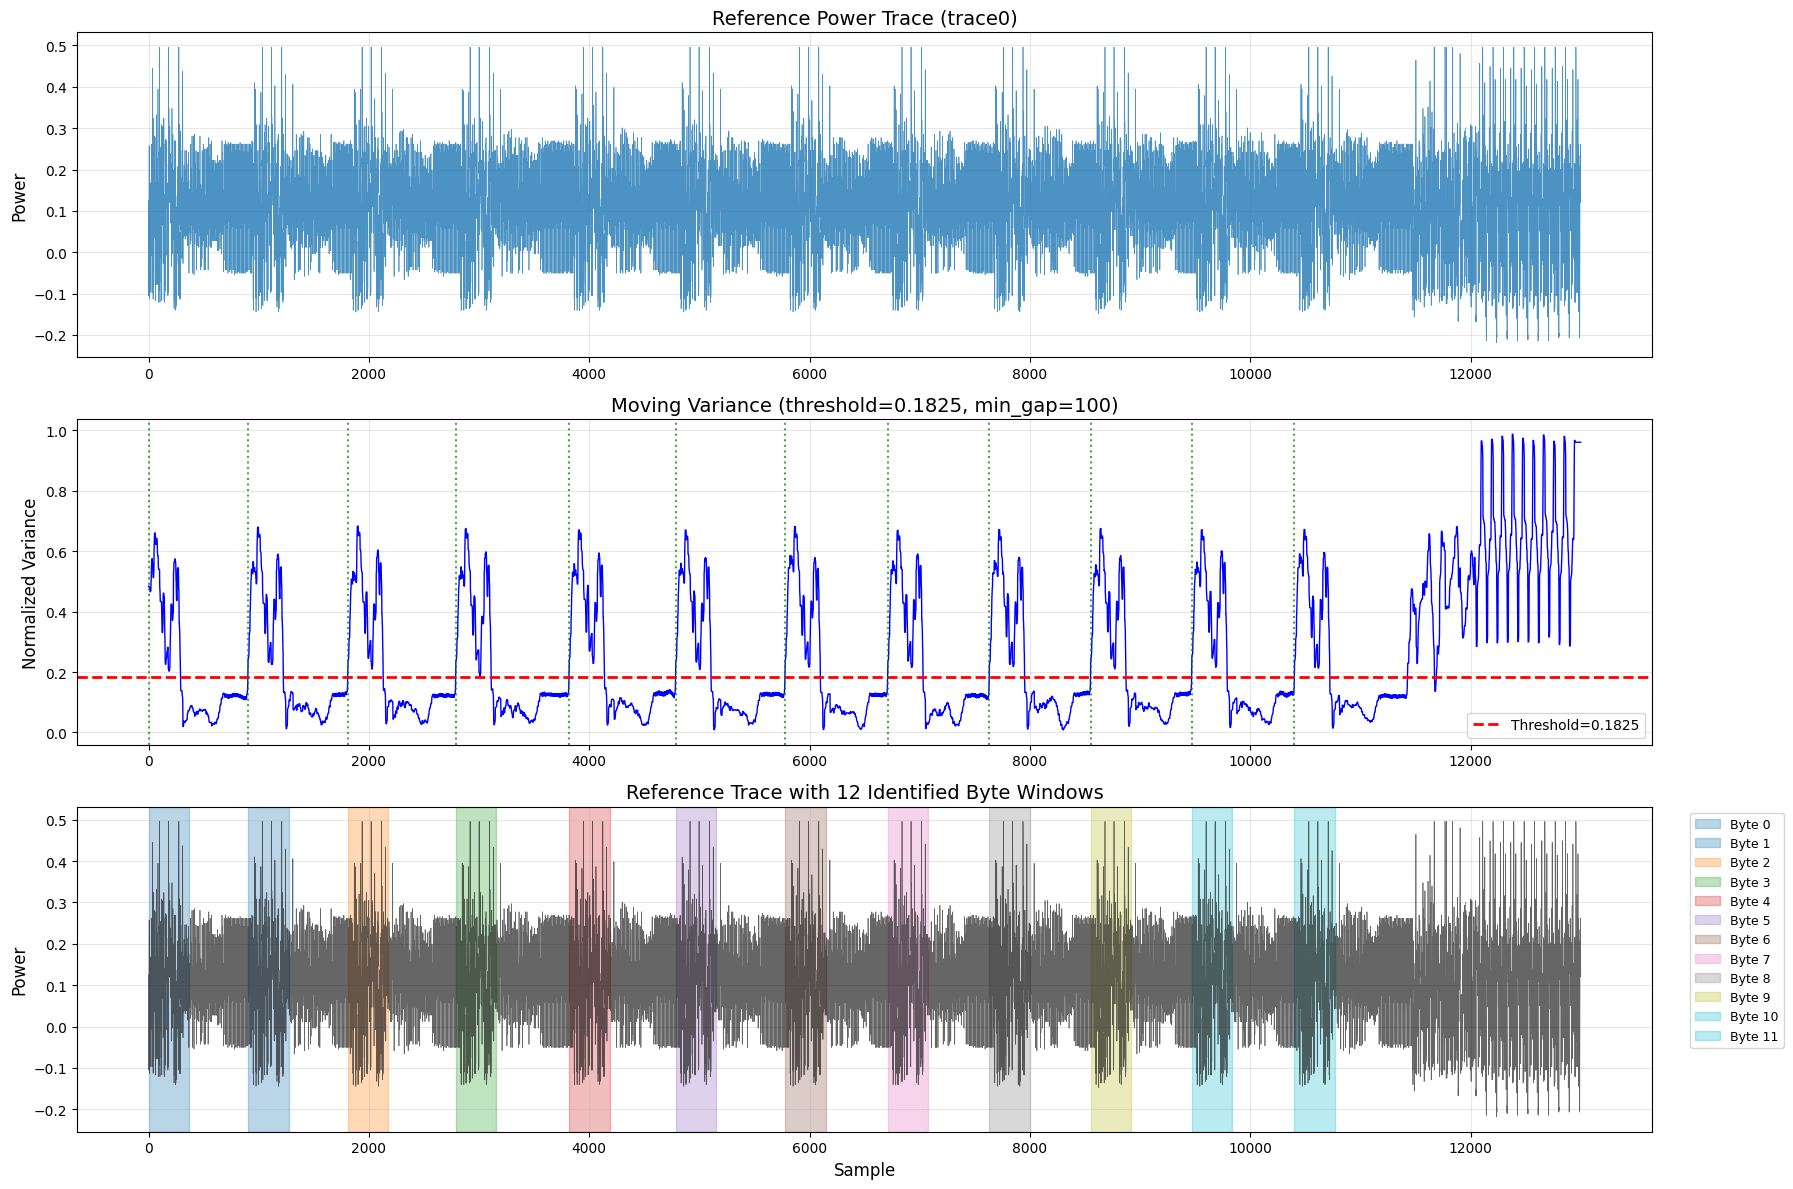


Window identification plot saved


In [5]:
print("\nIdentifying byte operation windows...")
ref_trace = traces[0]

windows = identify_byte_windows(
    ref_trace,
    num_bytes=NUM_BYTES,
    operation_width=OPERATION_WIDTH,
    threshold=THRESHOLD,
    min_gap=MIN_GAP,
    plot=True
)

### CPA

In [6]:
print("\nAligning traces and performing CPA attack...")
print("Model: correct &= (data[i] == password[i])")

num_bytes = len(windows)
num_traces = traces.shape[0]
bestguess = [0] * num_bytes
cparefs = [0] * num_bytes
all_correlations = []
alignment_info = []

for bnum, (ref_start, ref_end) in enumerate(windows):
    print(f"\nProcessing Byte {bnum} [reference window: {ref_start}:{ref_end}]")

    window_len = ref_end - ref_start

    if bnum == 0:
        print("  Byte 0: No alignment needed")
        aligned_windows = traces[:, ref_start:ref_end]
        aligned_starts = [ref_start] * num_traces
    else:
        print(f"  Aligning {num_traces} traces using SAD...")
        reference_window = ref_trace[ref_start:ref_end]
        aligned_windows = []
        aligned_starts = []

        for trace_idx in tqdm(range(num_traces), desc=f"  Aligning Byte {bnum}"):
            aligned_start, min_sad = align_trace_window(
                reference_window,
                traces[trace_idx],
                ref_start,
                search_window=SEARCH_WINDOW
            )
            aligned_starts.append(aligned_start)
            aligned_window = traces[trace_idx][aligned_start:aligned_start + window_len]
            aligned_windows.append(aligned_window)

        aligned_windows = np.array(aligned_windows)

        offsets = np.array(aligned_starts) - ref_start
        print(f"  Alignment stats: mean_offset={np.mean(offsets):.1f}, "
            f"std_offset={np.std(offsets):.1f}, "
            f"range=[{np.min(offsets)}, {np.max(offsets)}]")

    alignment_info.append(aligned_starts)

    plaintext_byte = plaintexts_array[:, bnum]

    

    print(f"  Performing CPA...")
    t_bar = mean(aligned_windows)
    o_t = std_dev(aligned_windows, t_bar)

    maxcpa = [0] * 256
    correlations_per_key = np.zeros((256, window_len))

    for kguess in range(256):
        hws = np.array([[HW[xor_internal(mask, kguess)] for mask in plaintexts_array[:, bnum]]]).transpose()
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(aligned_windows, t_bar, hws, hws_bar)
        cpaoutput = correlation / (o_t * o_hws)
        maxcpa[kguess] = max(cpaoutput)
        correlations_per_key[kguess, :] = cpaoutput

    bestguess[bnum] = (np.argsort(maxcpa)[-2] if np.argmax(maxcpa) == 0x00 else np.argmax(maxcpa))
    cparefs[bnum] = maxcpa[bestguess[bnum]]

    top3_indices = [k for k in np.argsort(maxcpa)[::-1] if k != 0x00][:3]

    print(f"  Top 3 key guesses:")
    for rank, key in enumerate(top3_indices, 1):
        corr = maxcpa[key]
        peak_sample = np.argmax(np.abs(correlations_per_key[key]))
        print(f"    {rank}. Key: 0x{key:02x} ({key:3d}) | Max |Corr|: {corr:.6f} | Peak at sample: {peak_sample}")

    all_correlations.append(correlations_per_key)

print("\nAttack Results:")
print("Best Key Guess: ", " ".join(f"{b:02x}" for b in bestguess))
print("Correlations:   ", " ".join(f"{c:.4f}" for c in cparefs))
print("\nRecovered Password (ASCII): " + "".join(chr(b) if 32 <= b < 127 else '.' for b in bestguess))


Aligning traces and performing CPA attack...
Model: correct &= (data[i] == password[i])

Processing Byte 0 [reference window: 0:370]
  Byte 0: No alignment needed
  Performing CPA...


/var/folders/4v/6j1rlyvd5lsb_qqj5y64nd0h0000gn/T/ipykernel_12725/103532229.py:62: RuntimeWarning: invalid value encountered in divide
  cpaoutput = correlation / (o_t * o_hws)


  Top 3 key guesses:
    1. Key: 0x70 (112) | Max |Corr|: 0.585590 | Peak at sample: 99
    2. Key: 0x6c (108) | Max |Corr|: 0.534178 | Peak at sample: 99
    3. Key: 0x68 (104) | Max |Corr|: 0.508415 | Peak at sample: 99

Processing Byte 1 [reference window: 902:1272]
  Aligning 5000 traces using SAD...


  Aligning Byte 1: 100%|██████████| 5000/5000 [00:09<00:00, 521.96it/s]


  Alignment stats: mean_offset=27.7, std_offset=41.6, range=[-152, 94]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x30 ( 48) | Max |Corr|: 0.597381 | Peak at sample: 131
    2. Key: 0x2c ( 44) | Max |Corr|: 0.514175 | Peak at sample: 131
    3. Key: 0x80 (128) | Max |Corr|: 0.488190 | Peak at sample: 131

Processing Byte 2 [reference window: 1808:2178]
  Aligning 5000 traces using SAD...


  Aligning Byte 2: 100%|██████████| 5000/5000 [00:09<00:00, 519.24it/s]


  Alignment stats: mean_offset=83.0, std_offset=58.5, range=[-186, 216]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x77 (119) | Max |Corr|: 0.562674 | Peak at sample: 131
    2. Key: 0x73 (115) | Max |Corr|: 0.510060 | Peak at sample: 131
    3. Key: 0x75 (117) | Max |Corr|: 0.472532 | Peak at sample: 131

Processing Byte 3 [reference window: 2788:3158]
  Aligning 5000 traces using SAD...


  Aligning Byte 3: 100%|██████████| 5000/5000 [00:09<00:00, 527.94it/s]


  Alignment stats: mean_offset=64.8, std_offset=72.0, range=[-280, 264]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x33 ( 51) | Max |Corr|: 0.594137 | Peak at sample: 131
    2. Key: 0x2f ( 47) | Max |Corr|: 0.485651 | Peak at sample: 131
    3. Key: 0x32 ( 50) | Max |Corr|: 0.485230 | Peak at sample: 131

Processing Byte 4 [reference window: 3816:4186]
  Aligning 5000 traces using SAD...


  Aligning Byte 4: 100%|██████████| 5000/5000 [00:09<00:00, 519.78it/s]


  Alignment stats: mean_offset=-1.9, std_offset=82.9, range=[-388, 248]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x72 (114) | Max |Corr|: 0.597125 | Peak at sample: 131
    2. Key: 0x6e (110) | Max |Corr|: 0.519112 | Peak at sample: 131
    3. Key: 0x6a (106) | Max |Corr|: 0.486277 | Peak at sample: 131

Processing Byte 5 [reference window: 4784:5154]
  Aligning 5000 traces using SAD...


  Aligning Byte 5: 100%|██████████| 5000/5000 [00:09<00:00, 522.40it/s]


  Alignment stats: mean_offset=-8.6, std_offset=91.7, range=[-356, 284]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x5f ( 95) | Max |Corr|: 0.588594 | Peak at sample: 131
    2. Key: 0x5b ( 91) | Max |Corr|: 0.536059 | Peak at sample: 131
    3. Key: 0x5d ( 93) | Max |Corr|: 0.490926 | Peak at sample: 131

Processing Byte 6 [reference window: 5776:6146]
  Aligning 5000 traces using SAD...


  Aligning Byte 6: 100%|██████████| 5000/5000 [00:09<00:00, 526.67it/s]


  Alignment stats: mean_offset=-38.5, std_offset=101.2, range=[-388, 282]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x77 (119) | Max |Corr|: 0.551626 | Peak at sample: 85
    2. Key: 0x73 (115) | Max |Corr|: 0.507472 | Peak at sample: 85
    3. Key: 0x6f (111) | Max |Corr|: 0.474024 | Peak at sample: 85

Processing Byte 7 [reference window: 6708:7078]
  Aligning 5000 traces using SAD...


  Aligning Byte 7: 100%|██████████| 5000/5000 [00:09<00:00, 522.22it/s]


  Alignment stats: mean_offset=-8.0, std_offset=108.6, range=[-400, 362]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x69 (105) | Max |Corr|: 0.625687 | Peak at sample: 85
    2. Key: 0x65 (101) | Max |Corr|: 0.526751 | Peak at sample: 85
    3. Key: 0x01 (  1) | Max |Corr|: 0.495170 | Peak at sample: 81

Processing Byte 8 [reference window: 7631:8001]
  Aligning 5000 traces using SAD...


  Aligning Byte 8: 100%|██████████| 5000/5000 [00:09<00:00, 522.10it/s]


  Alignment stats: mean_offset=31.6, std_offset=116.8, range=[-390, 400]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x74 (116) | Max |Corr|: 0.574993 | Peak at sample: 84
    2. Key: 0x70 (112) | Max |Corr|: 0.500666 | Peak at sample: 84
    3. Key: 0x6c (108) | Max |Corr|: 0.485530 | Peak at sample: 84

Processing Byte 9 [reference window: 8550:8920]
  Aligning 5000 traces using SAD...


  Aligning Byte 9: 100%|██████████| 5000/5000 [00:09<00:00, 524.76it/s]


  Alignment stats: mean_offset=72.1, std_offset=123.3, range=[-392, 400]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x68 (104) | Max |Corr|: 0.592022 | Peak at sample: 85
    2. Key: 0x64 (100) | Max |Corr|: 0.525394 | Peak at sample: 85
    3. Key: 0x60 ( 96) | Max |Corr|: 0.489340 | Peak at sample: 85

Processing Byte 10 [reference window: 9467:9837]
  Aligning 5000 traces using SAD...


  Aligning Byte 10: 100%|██████████| 5000/5000 [00:09<00:00, 525.05it/s]


  Alignment stats: mean_offset=110.5, std_offset=127.6, range=[-368, 400]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x31 ( 49) | Max |Corr|: 0.556427 | Peak at sample: 84
    2. Key: 0x30 ( 48) | Max |Corr|: 0.447462 | Peak at sample: 84
    3. Key: 0x2f ( 47) | Max |Corr|: 0.423899 | Peak at sample: 84

Processing Byte 11 [reference window: 10400:10770]
  Aligning 5000 traces using SAD...


  Aligning Byte 11: 100%|██████████| 5000/5000 [00:09<00:00, 524.79it/s]


  Alignment stats: mean_offset=131.4, std_offset=131.3, range=[-400, 400]
  Performing CPA...
  Top 3 key guesses:
    1. Key: 0x6e (110) | Max |Corr|: 0.415252 | Peak at sample: 90
    2. Key: 0x6c (108) | Max |Corr|: 0.396518 | Peak at sample: 83
    3. Key: 0x6a (106) | Max |Corr|: 0.389193 | Peak at sample: 83

Attack Results:
Best Key Guess:  70 30 77 33 72 5f 77 69 74 68 31 6e
Correlations:    0.5856 0.5974 0.5627 0.5941 0.5971 0.5886 0.5516 0.6257 0.5750 0.5920 0.5564 0.4153

Recovered Password (ASCII): p0w3r_with1n
